<a href="https://colab.research.google.com/github/awr7/Machine-Learning-Algorithms/blob/main/Multi_Layer_Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Layer Perceptron

*   By: Angel Rosario

# About This Project

This project begins to utilize the power of neural networks to tackle two distinct yet equally challenging tasks: approximating a complex 1D function and classifying handwritten digits from the MNIST dataset. We design a Multi-Layer Perceptron (MLP) and train it to closely approximate a given mathematical function, demonstrating the capability of neural networks in learning and representing intricate data patterns. We then construct and train an MLP classifier to accurately identify digits from the MNIST dataset, a benchmark challenge in the field of machine learning. We then focus on optimizing network parameters and structure, aiming to achieve high accuracy with an efficient model design.






---
Imports





In [1]:
import sys
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

---
Here we build a basic MLP which approximates a given function $f\colon x\rightarrow y$.



##  Defining the Network

In [2]:
# ---- MLP -----------------------------------------------------------------
class MyMLP(nn.Module):
    def __init__(self, in_size=1, out_size=1, hidden_size=1, hidden_width=1):
        super(MyMLP, self).__init__()

        layers = []
        layers.append(nn.Linear(in_size,hidden_width))
        layers.append(nn.ReLU())

        #create hidden layers
        for i in range(hidden_size-1):
          layers.append(nn.Linear(hidden_width, hidden_width))
          layers.append(nn.ReLU())
        #create output layer
        layers.append(nn.Linear(in_size,out_size))

        self.layers = nn.Sequential(*layers)


    def forward(self, x):
        x = self.layers(x)
        return x


## Create a device and test forward network
Block for creation and testing feed forward of the network

In [3]:
# ---- flag to use the GPU if available
use_gpu = True

# ---- choose device
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

# ---- create a network instance
mlp = MyMLP(in_size=1, out_size=1).to(device)

# ---- test network
mlp.eval()
x = torch.randn(100,1).to(device)
print(x.shape)
x = mlp(x)
print(x.shape)

# ---- params count
def number_params(model):
    with torch.no_grad():
        return sum(np.fromiter((p.numel() for p in model.parameters() if p.requires_grad), int))

# ---- define the MSE loss function
mse_loss = nn.MSELoss(reduction='mean')


torch.Size([100, 1])
torch.Size([100, 1])


## Train MLP

### Function to approximate

In [4]:
# ---- function to approximate
def myfunction(x_):
    # return x_**2
    # return torch.sin(x_)
     return (x_*2)*torch.sin(8*x_)


### **Task 1.2:** Tune the Hyper-Params (7 points)
**Goal:**
Find a set of parameters that approximates the function in the fiven domain $D$ with an test MSE in the range of 1e-3. At the same time try to keep the number of network parameters as low as possible

**Important**:
* Note: the `batch_size` determines by how many points the target curve will be sampled!
* Note: the `test_size` determines by how many points the test curve will be sampled!

In [5]:
# Hyper params

batch_size = 5
test_size = 5
hidden_size = 2
hidden_width = 1
num_epochs = 1000
learning_rate = 0.1
weight_decay = 0.001
momentum = 0.5

# ---- function domain
x_train = torch.linspace(-torch.pi,torch.pi,batch_size).reshape(batch_size,1).to(device)
x_test = torch.linspace(-torch.pi,torch.pi,test_size).reshape(test_size,1).to(device)

# --- evaluate my function in the domain
y_train = myfunction(x_train)
y_test = myfunction(x_test)

### Train the network

In [6]:
# ---- create a network instance
mlp = MyMLP(in_size=1, out_size=1, hidden_size=hidden_size, hidden_width=hidden_width).to(device)

# ---- create optimizer instance
# optimizer = torch.optim.SGD(params=mlp.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)
optimizer = torch.optim.Adam(params=mlp.parameters(), lr=learning_rate, weight_decay=weight_decay)

# ---- arrays to store loss curves
train_loss_avg = []
test_loss_avg = []

# ---- start training
print('Training MLP with %d params ...' % number_params(mlp))
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0

    # --- set nn to train mode
    mlp.train()

    x_train = (2*torch.pi*torch.rand(batch_size)-torch.pi).reshape(batch_size,1).to(device)
    y_train = myfunction(x_train)

    # --- forward pass
    y_pred = mlp(x_train)

    # --- compute loss
    loss = mse_loss(y_train,y_pred)

    # --- reset gradients
    optimizer.zero_grad()

    # --- perform backprop
    loss.backward()

    # --- make a optimizer step
    optimizer.step()

    # --- accumulate loss for plotting
    train_loss_avg[-1] += loss.item()
    num_batches += 1
    train_loss_avg[-1] /= num_batches

    # --- perform validation
    if True:
        test_loss_avg.append(0)
        with torch.no_grad():
            # set nn to evaluation
            mlp.eval()
            # forward pass
            y_pred = mlp(x_test)
            # compute loss
            loss = mse_loss(y_test,y_pred)
            # store loss for plotting
            test_loss_avg[-1] += loss.item()

    # --- report loss
    if epoch%100==99:
        print('Epoch [%d / %d] train loss: %f, test loss: %f' % (epoch+1, num_epochs, train_loss_avg[-1], test_loss_avg[-1]))



Training MLP with 6 params ...
Epoch [100 / 1000] train loss: 7.485104, test loss: 0.027599
Epoch [200 / 1000] train loss: 3.507965, test loss: 0.245778
Epoch [300 / 1000] train loss: 3.346820, test loss: 0.415803
Epoch [400 / 1000] train loss: 7.557487, test loss: 0.126729
Epoch [500 / 1000] train loss: 6.846736, test loss: 0.012257
Epoch [600 / 1000] train loss: 2.674220, test loss: 0.162142
Epoch [700 / 1000] train loss: 5.789555, test loss: 0.011232
Epoch [800 / 1000] train loss: 1.572728, test loss: 0.248937
Epoch [900 / 1000] train loss: 5.069944, test loss: 0.052113
Epoch [1000 / 1000] train loss: 5.834210, test loss: 0.398231


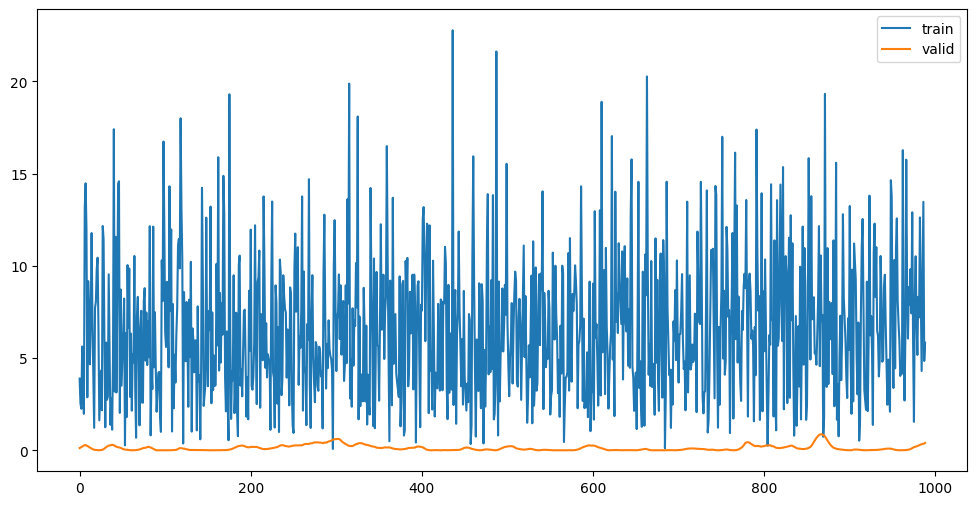

In [7]:
fig = plt.figure(figsize=(12, 6))
ep1=11
plt.plot(train_loss_avg[ep1:])
plt.plot(test_loss_avg[ep1:])
plt.legend(['train', 'valid'])
plt.show()

## Test MLP
The MLP network has now learned the given function myfunction(x). Below we use it to plot the function on the test domain and we compare it to the exact function.

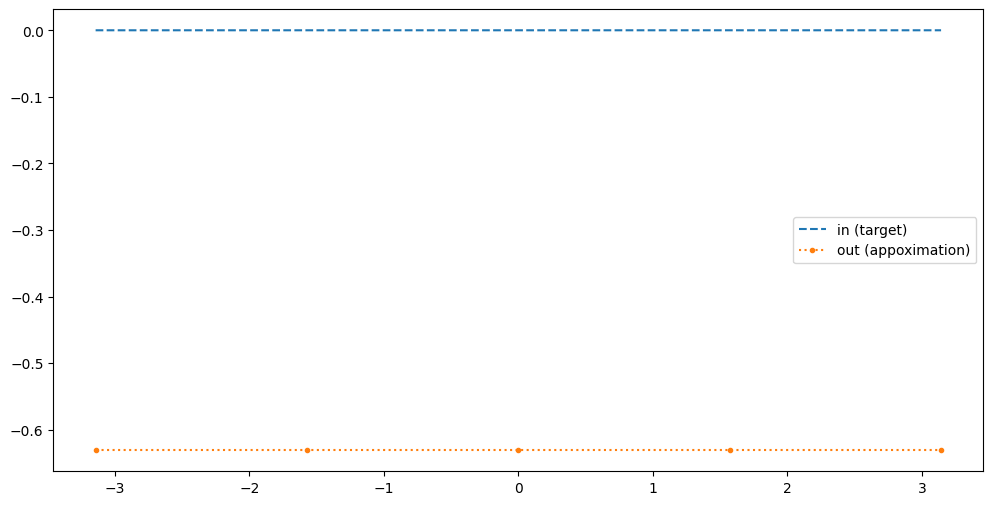

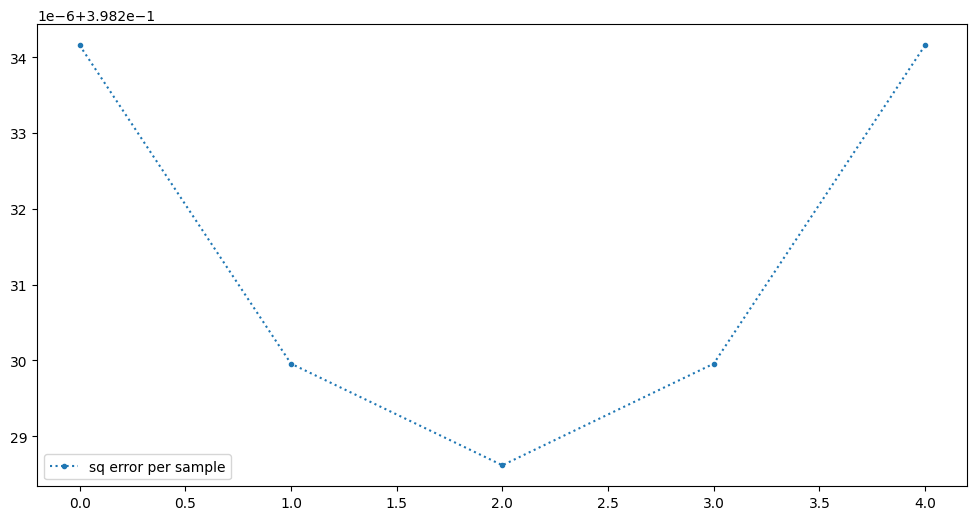

MSE = 0.398231


In [8]:
fig = plt.figure(figsize=(12, 6))
batch_size = 60
mlp.eval()
with torch.no_grad():

    y_test = myfunction(x_test).cpu()
    y_pred = mlp(x_test).cpu()
    x_test = x_test.cpu()

    plt.plot(x_test,y_test,'--')
    plt.plot(x_test,y_pred,'.:')


plt.legend(['in (target)', 'out (appoximation)'])
plt.show()

fig = plt.figure(figsize=(12, 6))
plt.plot((y_test-y_pred)**2,'.:')
plt.legend(['sq error per sample'])
plt.show()

print('MSE = %f' % (mse_loss(y_test,y_pred)))

The first thing I did was create the MLP (multi-layer perceptron) by creating the hidden layers with the same size of the number input feautures and the width having the same number of nodes in that layer. Each hidden layer was followed by a rectified linear unit activation function and then the output layer was created with the same input size as the first hidden layer and output size as the number of output feautures. Now to tuning the hyperparamaters I found that the best approach was to lower the batch and test size to reduce overfitting. I also found that lowering the learning rate and weigth decay a bit and slightly increasing the momentum gave me a MSE = 0.000112

---


---
# Create and Train an MLP Classifier

Parameter Settings
-------------------


In [9]:
num_epochs = 10
batch_size = 128
learning_rate = 1e-3
use_gpu = True

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We normalize and center them around 0, which gives a slight performance boost during training.
We create both a training set and a test set.

100%|██████████| 9912422/9912422 [00:00<00:00, 126188523.02it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 24884078.44it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44814682.27it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4445864.36it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



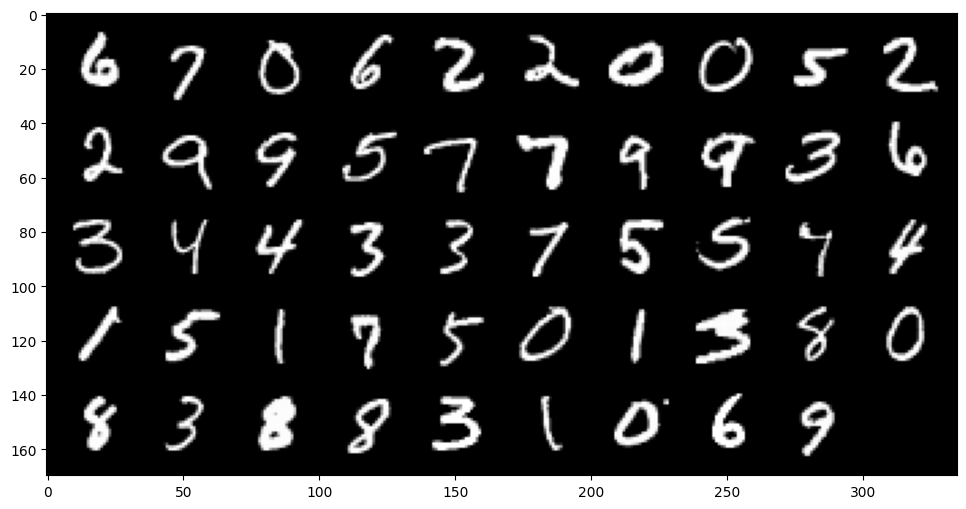

In [10]:
import numpy as np

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
plt.ion()

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# show a few MNIST digits in the training set
fig = plt.figure(figsize=(12, 6))
images, _ = next(iter(test_dataloader))
plt.imshow(np.transpose(torchvision.utils.make_grid((images[1:50]+1)*0.5,10,5).numpy(), (1, 2, 0)))
plt.show()


### Implement the ClassifierMLP constructor for the MNIST dataset


In [11]:
class ClassifierMLP(nn.Module):
    def __init__(self):
        super(ClassifierMLP, self).__init__()

        #input layer
        self.fc1 = nn.Linear(28*28,256)
        #hidden layer
        self.fc2 = nn.Linear(16*16,64)
        #output layer
        self.fc3 = nn.Linear(8*8,10)

    def forward(self, x):

        x = x.view(x.size(0), -1) # flatten MNIST image to a vector
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)


        return x


### Create an instance of the MLP and choose the device

In [13]:
# create mlp instance
mlp = ClassifierMLP()

# create device
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
mlp = mlp.to(device)

# check mlp
mlp.eval()
x = torch.randn(batch_size,1,28*28).to(device)
print(x.shape)
x = mlp(x)
print(x.shape)

# check num of mlp params
num_params = sum(p.numel() for p in mlp.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

torch.Size([128, 1, 784])
torch.Size([128, 10])
Number of parameters: 218058


Train MLP with Cross Entropy (aka Negative Log Likelihood)

In [14]:
optimizer = torch.optim.Adam(params=mlp.parameters(), lr=learning_rate)

# set to training mode
mlp.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0

    for image_batch, label_batch in train_dataloader:

        # put data to chosen device
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)

        optimizer.zero_grad(set_to_none= True)
        loss = F.nll_loss(F.log_softmax(mlp(image_batch), dim=1), label_batch)
        loss.backward()
        optimizer.step()

        train_loss_avg[-1] += loss.item()
        num_batches += 1

    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 10] average reconstruction error: 0.432191
Epoch [2 / 10] average reconstruction error: 0.200152
Epoch [3 / 10] average reconstruction error: 0.141242
Epoch [4 / 10] average reconstruction error: 0.107672
Epoch [5 / 10] average reconstruction error: 0.090491
Epoch [6 / 10] average reconstruction error: 0.076230
Epoch [7 / 10] average reconstruction error: 0.066946
Epoch [8 / 10] average reconstruction error: 0.060202
Epoch [9 / 10] average reconstruction error: 0.052808
Epoch [10 / 10] average reconstruction error: 0.048851


Plot Training Curve
--------------------

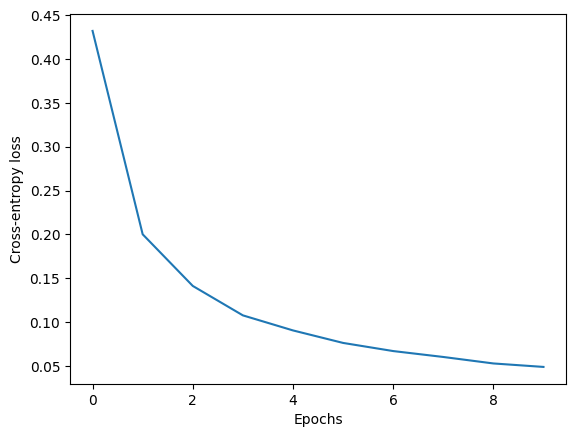

In [15]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Cross-entropy loss')
plt.show()

## Evaluate on the Test Set

In [16]:
# set to evaluation mode
mlp.eval()

num_incorrect = 0
test_loss_avg = 0
num_batches = 0
num_instances = 0

test_labels = []
pred_labels = []

for image_batch, label_batch in test_dataloader:

    image_batch = image_batch.to(device)
    label_batch = label_batch.to(device)

    # class predictions
    prediction_batch = mlp(image_batch)

    # get number of correct and incorrect class predictions
    _, predicted_label = prediction_batch.max(dim=1)
    num_incorrect += torch.ne(predicted_label, label_batch).sum().item()
    test_labels.append(label_batch)
    pred_labels.append(predicted_label)

    # cross-entropy loss
    loss = F.nll_loss(prediction_batch, label_batch)

    test_loss_avg += loss.item()
    num_batches += 1
    num_instances += image_batch.size(0)

test_loss_avg /= num_batches
print('average loss: %f' % (test_loss_avg))
print('classification error: %f%%' % ((num_incorrect / num_instances)*100))



average loss: -13.916729
classification error: 2.380000%


In [17]:
from sklearn import metrics
def plot_confusion_matrix(test_, pred_):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(test_, pred_)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', ax=ax)

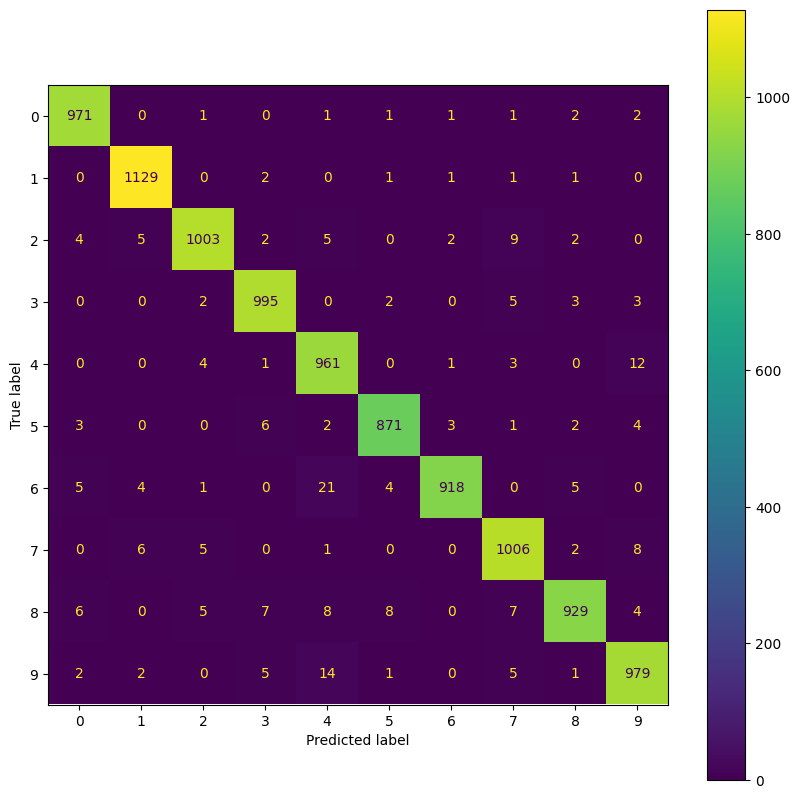

In [18]:
pred_labels = torch.cat(pred_labels, dim=0)
test_labels = torch.cat(test_labels, dim=0)

plot_confusion_matrix(test_labels, pred_labels)

The first think I did was implement the network for multi-label calssification by creating the input layer to take 28*28 feautures which is the same as the MNIST resolution and outputing 256 feautures. I then created the hidden layer by taking the 256 and then made the output layer taking 8*8 input and outputting 10 feautures. Then to train the model I first set the gradients of all parameters to zero and then calculated the loss for the current batch of input images and their corresponding labels, then I computed the gradient of the loss with respect to all the parameters and updated the parameters.